In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from ignite.metrics import Accuracy as acc
import torch.optim as optim
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as accuracy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train=pd.read_csv('/kaggle/input/train-dig/train.csv')
print(len(train))
train.head(3)

42000


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test=pd.read_csv('/kaggle/input/test-dig/test.csv')
print(len(test))
test.head(2)

28000


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.label.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
train_f=train.drop('label', axis=1)
label=train.label

In [6]:
label_ar=np.array(label)
label_tens=torch.tensor(label_ar).int()
label_tens.shape

torch.Size([42000])

In [7]:
train_ar=np.array(train_f)
train_tens=torch.tensor(train_ar).int()
train_tens=train_tens.reshape((42000,28,28))

test_ar=np.array(test)
test_tens=torch.tensor(test_ar).int()
test_tens=test_tens.reshape((28000,28,28))

train_tens.shape, test_tens.shape

(torch.Size([42000, 28, 28]), torch.Size([28000, 28, 28]))

In [8]:
mean_t=train_tens.float().mean()
std_t=train_tens.float().std()
mean_t, std_t

(tensor(33.4089), tensor(78.6777))

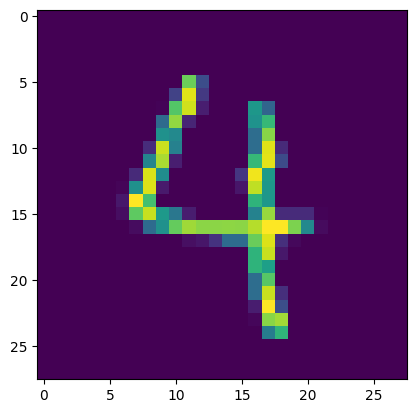

In [9]:
plt.imshow(train_tens[999,:,:])

In [10]:
#dir(transforms)

In [11]:
normalize=transforms.Normalize(mean_t, std_t)
train_norm=normalize(train_tens.float())
test_norm=normalize(test_tens.float())

In [12]:
test_norm.mean(), test_norm.std()

(tensor(-0.0007), tensor(0.9993))

In [13]:
class mnistDataset(Dataset):
    def __init__(self, mnist_tens, label_tens, is_train=True):
        self.mnist_tens=mnist_tens
        self.label_tens=label_tens
        self.is_train=is_train        
    def __len__(self):
        return len(self.mnist_tens)
    def __getitem__(self, index):
        target=torch.zeros(10)
        if self.is_train:
            image=self.mnist_tens[index,:,:]
            ind=self.label_tens[index]
            target[ind]=1
        
            return {'image': image.unsqueeze(0), 'label': target.to(torch.short)}  
        else:
            image=self.mnist_tens[index,:,:]
            return {'image': image.unsqueeze(0)}
    
    def get_num_batches(self, batch_size):
        
        return len(self) // batch_size

    

In [14]:
data=mnistDataset(train_norm, label_tens, is_train=True)
w=data.__getitem__(1)
#w

In [15]:
w['label'].shape, w['image'].shape

(torch.Size([10]), torch.Size([1, 28, 28]))

In [16]:
def generate_batches(dataset, batch_size, shuffle=True,drop_last=True, device='cpu'):

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
            
        yield out_data_dict
        

In [17]:
gen=generate_batches(data,3)
ww=next(gen)
ww

{'image': tensor([[[[-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           ...,
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246]]],
 
 
         [[[-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           ...,
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246],
           [-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246]]],
 
 
         [[[-0.4246, -0.4246, -0.4246,  ..., -0.4246, -0.4246, -0.4246]

In [18]:
ww['label'].shape, ww['image'].shape

(torch.Size([3, 10]), torch.Size([3, 1, 28, 28]))

In [19]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [20]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=36):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(1, n_chans1, kernel_size=5, padding=2)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        #self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//4, kernel_size=3, padding=2)
        #self.conv3_dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(7*7* n_chans1 //2, 128)
        #self.fc1_1=nn.Linear(200,100 )
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        out = F.max_pool2d(F.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(F.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        #out = F.max_pool2d(F.tanh(self.conv3(out)), 2)
        #out = self.conv3_dropout(out)
        out = out.view(-1, 7 * 7*self.n_chans1 //2)
        out = F.tanh(self.fc1(out))
        #out = F.tanh(self.fc1_1(out))
        out = self.fc2(out)
        return out


In [21]:
model=NetDropout()
model

NetDropout(
  (conv1): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(36, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=882, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
n_samples=train_norm.shape[0]
n_val=int(0.2*n_samples)
shuffled_indices = torch.randperm(n_samples)
train_ind=shuffled_indices[:-n_val]
val_ind=shuffled_indices[-n_val:]
data_train=train_norm[train_ind,:,:]
data_val=train_norm[val_ind,:,:]
label_train=label_tens[train_ind]
label_val=label_tens[val_ind]
data_train.shape, data_val.shape, len(label_train), len(label_val)


(torch.Size([33600, 28, 28]), torch.Size([8400, 28, 28]), 33600, 8400)

In [23]:
d_train=mnistDataset(data_train, label_train, is_train=True)
d_val=mnistDataset(data_val, label_val, is_train=True)

In [24]:
def training_loop(n_epochs, optimizer, model, loss_fn):
    N_train=d_train.__len__()//64
    N_val=d_val.__len__()//64
    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0        
        train_loader = generate_batches(dataset=d_train,batch_size=64, shuffle=True, \
                                        drop_last=True, device=device)
        
        for batch_index, data_dict in enumerate(train_loader):
            imgs = data_dict['image'].to(device=device)
            labels = data_dict['label'].to(dtype=torch.float32, device=device)
            outputs = model(imgs)            
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()                
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train/N_train))
            
            val_loader = generate_batches(dataset=d_val,batch_size=64, shuffle=True, \
                                        drop_last=True, device=device)
            model.eval()
            score=0
            for batch_index, data_dict in enumerate(val_loader):
                imgs=data_dict['image'].to(device=device)
                labels=data_dict['label'].to(device='cpu')                
                with torch.no_grad(): 
                    pred_val = model(imgs)
                    y_val=torch.argmax(pred_val, dim=1).detach().to('cpu').numpy()
                    y_true=torch.argmax(labels, dim=1).numpy()
                    score+=accuracy(y_true, y_val)
            
            print('Epoch {}, Val_accuracy {}'.format(epoch, score/N_val))             
   

In [25]:
model = NetDropout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
 n_epochs = 300,
 optimizer = optimizer,
 model = model,
 loss_fn = loss_fn
 )

Epoch 1, Training loss 1.4276160698845273
Epoch 1, Val_accuracy 0.8255009541984732
Epoch 10, Training loss 0.16762295744248798
Epoch 10, Val_accuracy 0.9606393129770993
Epoch 20, Training loss 0.10699370759228866
Epoch 20, Val_accuracy 0.9734017175572519
Epoch 30, Training loss 0.08669285386623371
Epoch 30, Val_accuracy 0.9786498091603053
Epoch 40, Training loss 0.07085389917095503
Epoch 40, Val_accuracy 0.9798425572519084
Epoch 50, Training loss 0.06402480592596389
Epoch 50, Val_accuracy 0.9821087786259542
Epoch 60, Training loss 0.0549946943679381
Epoch 60, Val_accuracy 0.982824427480916
Epoch 70, Training loss 0.05093305993869546
Epoch 70, Val_accuracy 0.9842557251908397
Epoch 80, Training loss 0.04679957331069523
Epoch 80, Val_accuracy 0.9848520992366412
Epoch 90, Training loss 0.0444366097800611
Epoch 90, Val_accuracy 0.9854484732824428
Epoch 100, Training loss 0.040978589448412615
Epoch 100, Val_accuracy 0.9860448473282443
Epoch 110, Training loss 0.037414448267026314
Epoch 110, 

In [26]:
train_all=mnistDataset(train_norm, label_tens, is_train=True)
test_all=mnistDataset(test_norm, label_val, is_train=False)

In [27]:
def train_model (n_epochs, optimizer, model, loss_fn):
    N_train=train_all.__len__()//64
    model.train()
    for epoch in range(1, n_epochs + 1):        
        loss_train = 0.0        
        train_loader = generate_batches(dataset=train_all,batch_size=64, shuffle=True, \
                                        drop_last=False, device=device)
        
        for batch_index, data_dict in enumerate(train_loader):
            imgs = data_dict['image'].to(device=device)
            labels = data_dict['label'].to(dtype=torch.float32, device=device)
            outputs = model(imgs)            
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()                
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train/N_train))
    return model

In [28]:
model = NetDropout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
model_train=train_model( n_epochs = 300, optimizer = optimizer, model = model,loss_fn = loss_fn)

Epoch 1, Training loss 1.1773514375999206
Epoch 10, Training loss 0.163368120369297
Epoch 20, Training loss 0.10526968367829374
Epoch 30, Training loss 0.08257736163724941
Epoch 40, Training loss 0.06867735786363482
Epoch 50, Training loss 0.05803410791246811
Epoch 60, Training loss 0.05304402050990952
Epoch 70, Training loss 0.04716308869603558
Epoch 80, Training loss 0.04282475925382886
Epoch 90, Training loss 0.040247981548351915
Epoch 100, Training loss 0.03716956812600185
Epoch 110, Training loss 0.03511662693536647
Epoch 120, Training loss 0.03183532371409323
Epoch 130, Training loss 0.02973853888504048
Epoch 140, Training loss 0.029511679136747973
Epoch 150, Training loss 0.027495823270306217
Epoch 160, Training loss 0.02537602273771815
Epoch 170, Training loss 0.0239898158596167
Epoch 180, Training loss 0.02210084633016533
Epoch 190, Training loss 0.02241968165298004
Epoch 200, Training loss 0.020785950648310174
Epoch 210, Training loss 0.020216560365774856
Epoch 220, Training 

In [29]:
def test_pred (model):
    N_test=test_all.__len__()//64
    prediction=np.empty(0)
    model.eval()              
    test_loader = generate_batches(dataset=test_all,batch_size=64, shuffle=False, \
                                    drop_last=False, device=device)
        
    for batch_index, data_dict in enumerate(test_loader):
        imgs=data_dict['image'].to(device=device)                               
        with torch.no_grad(): 
            pred_test = model(imgs)
            y_test=torch.argmax(pred_test.detach(), dim=1).to('cpu').numpy()                    
            prediction=np.concatenate((prediction, y_test))
    return prediction.astype(int)

In [30]:
y_pred=test_pred(model_train)
len(y_pred)

28000

In [31]:
subm=pd.read_csv('/kaggle/input/sampl-dig/sample_submission.csv')
subm

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [32]:
subm['Label']=y_pred
subm

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [33]:
subm.isnull().sum()

ImageId    0
Label      0
dtype: int64

In [34]:
subm.to_csv('subm_2.csv', index=False)